In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
#rc('text', usetex=False) # para usar latex en matplotlib
from matplotlib import animation # animaciones
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
import pandas as pd

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra \
**Integrantes:** Diego Dominguez, Rodrigo Fuentes, Branco Paineman y Sebastián Rojas.

# Laboratorio 3

El objetivo de este laboratorio es entender e implementar un esquema numérico basado en elementos finitos de Lagrange para una ecuacion elíptica de segundo orden en una dimensión con condiciones de frontera Dirichlet.

Sean $\alpha,\beta,u_{\alpha},u_{\beta}\in\mathbb{R}$, $\varepsilon>0$,
$\Omega=\left(  \alpha,\beta\right)  $, $a\in W^{1,\infty}\left(
\Omega\right)  $, $b\in L^{\infty}\left(  \Omega\right)  $ y $f\in
L^{2}\left(  \Omega\right)  $. 

Considere la siguiente ecuación de difusión-advección-reacción dada por
$\begin{align}
-\varepsilon u^{\prime\prime}+au^{\prime}+bu  &  =f\qquad\text{sobre }%
\Omega\nonumber\\
u\left(  \alpha\right)   &  =u_{\alpha}\tag{P}\\
u\left(  \beta\right)   &  =u_{\beta}\nonumber
\end{align}$

### **Ejercicio 1:**

Programe una funcion que resuelva numéricamente el problema (P) usando el metodo descrito. Las entradas del programa deben ser la discretización $\{x_j\}^{N+1}_{j=0}$ como un vector ordenado, $u_\alpha$,$u_\beta$, $\varepsilon$, $a$, $b$ y $f$. 

La salida de este programa debe ser un vector del mismo tamaño que la discretización con las soluciones discretas del esquema.

In [2]:
# función para generar la matriz Ah
def Ah(h,eps,a,b):
    # construimos la primera matriz en la suma para generar A
    N=len(h)-1
    e=[1/h[0]]
    for i in range(0,N):
        e.append(1/h[i]+1/h[i+1])
    e.append(1/h[N])
    e=np.array(e)
    f=-1/h
    k = np.array([f,e,f], dtype= object) 
    offset = [-1,0,1] 
    A1 = diags(k,offset)
    
    # construimos la segunda matriz en la suma para generar A
    e2=np.zeros(N+2)
    e2[0]=-1/2
    e2[-1]=1/2
    f2=np.ones(N+1)
    k2 = np.array([-f2/2,e2,f2/2], dtype= object) 
    offset2 = [-1,0,1]
    A2 = diags(k2,offset2)
    
    # construimos la tercera matriz en la suma para generar A
    e3=[h[0]]
    for i in range(0,N):
        e3.append(h[i]+h[i+1])
    e3.append(h[N])
    e3=2*np.array(e3)
    k3 = np.array([h,e3,h], dtype= object) 
    offset = [-1,0,1] 
    A3 = diags(k3,offset)
    
    return eps*A1+a*A2+b/6*A3

# función para generar fh
def fh(h,x,f):
    N=len(h)-1
    F=np.zeros(N+2)
    F[0]=h[0]*(f(x[0])+2*f((x[0]+x[1])/2))
    for i in range(1,N+1):
            F[i]=h[i]*(f(x[i])+2*f((x[i]+x[i+1])/2))+h[i-1]*(f(x[i])+2*f((x[i-1]+x[i])/2))
    F[-1]=h[N]*(f(x[N+1])+2*f((x[N]+x[N+1])/2))
    F=F/6
    return F
    

def Resuelve(x,ualpha,ubeta,eps,a,b,f):
    # creamos un vector h con los valores h0,...,hN
    h=[]
    for i in range(len(x)-1):
        h.append(x[i+1]-x[i])
    h=np.array(h)
    N=len(x)-2
    
    #creamos la matriz A
    A=Ah(h,eps,a,b).todense()
    
    # creamos el término que se le resta a fh antes de resolver el sistema
    G=np.zeros(N)
    G[0]=A[1,0]*ualpha
    G[-1]=A[N,N+1]*ubeta
    
    # quitamos los bordes de la matriz A
    A=A[1:-1,:]
    A=A[:,1:-1]
    
    # creamos fh y le quitamos los extremos
    F=fh(h,x,f)
    F=F[1:-1]
    # Resolvemos el sistema lineal
    u_= np.linalg.solve(A,F-G)
    # Agregamos las condiciones de borde
    u=np.zeros(N+2)
    u[1:-1]=u_
    u[0]=ualpha
    u[-1]=ubeta
    return u

### **Ejercicio 2:** 
Considere $f\equiv1$, $a=1$, $b=0$ y $\Omega=\left(  0,1\right)  $.

Para $u_{\alpha}=u_{\beta}=0$, la solución analítica de $\textbf{(P)}$ es única e igual a la
función
$$
u(x)=x-\dfrac
{\exp\left(  \frac{x-1}{\varepsilon}\right)  -\exp\left(  -\frac
{1}{\varepsilon}\right)  }{1-\exp\left(  -\frac{1}{\varepsilon}\right)}\hspace{1cm} \forall x\in\left[  0,1\right] 
$$

a. Para una discretización uniforme con $N \in \{5, 10, 20\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$), calcule la solución numérica cuando $\varepsilon = 1$. Grafique todas las soluciones numéricas y la solución analítica (esta última discretizada en una gran cantidad de puntos equiespaciados) en una misma gráfica. Comente sus observaciones.

In [3]:
#Parametros
f= lambda x: 1
a=1
b=0
ualpha=0
ubeta=0
eps=1
N_=[5,10,20]

In [4]:
def u(x,eps):
    return x-(np.exp((x-1)/eps)-np.exp(-1/eps))/(1-np.exp(-1/eps))

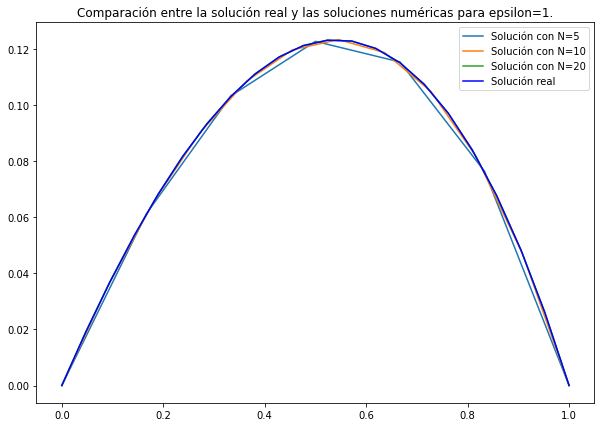

In [5]:
fig=plt.figure(figsize=(10,7))
for i in range(len(N_)):
    x=np.linspace(0,1,N_[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=1.')
plt.legend()

Podemos observar que a medida que se aumenta el valor de $N$, la curva de la solución aproximada se hace más suave y se acerca más a la solución real. En particular, para el $N=5$, se pueden observar puntos donde se nota una clara diferencia entre la solución aproximada y la real, para $N=10$ sólo se ven pequeñas diferencias entre ambas curvas, y para $N=20$ es imposible notar diferencias a simple vista, lo que resulta en una aproximación muy certera.

b. Repita lo anterior para $\varepsilon = 10^{−j}$ , con $j \in \{1, 2, 3\}$ y $N \in \{10, 25, 50, 100, 250, 500, 1000\}$. Gráfique los tres primeros valores de $N$ en una figura, los dos siguientes en una distinta y los últimos dos en otra. 
    
Comente sus observaciones.

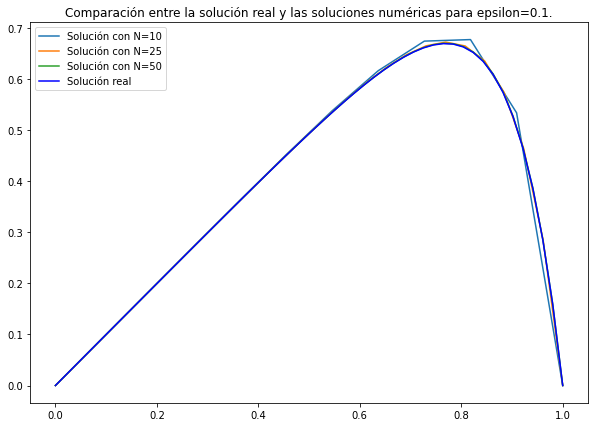

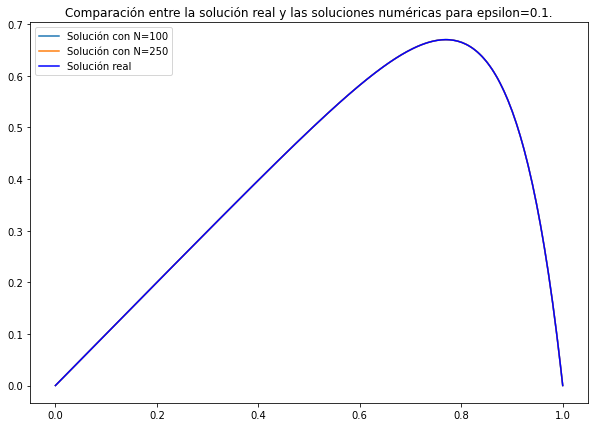

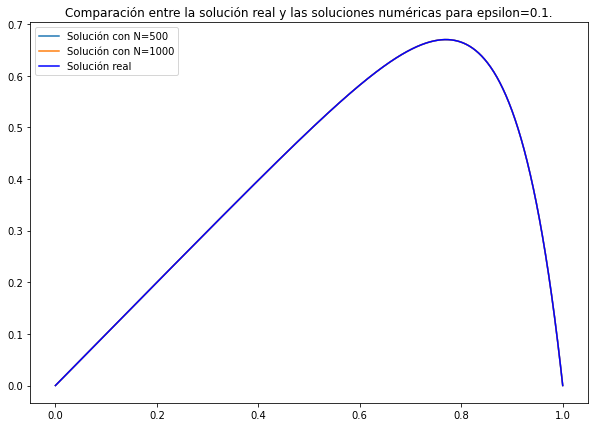

In [6]:
eps2=[10**(-1),10**(-2),10**(-3)]
N_2=[10,25,50,100,250,500,1000]

fig=plt.figure(figsize=(10,7))
for i in range(0,3):
    eps_=eps2[0]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.1.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(3,5):
    eps_=eps2[0]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.1.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(5,7):
    eps_=eps2[0]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.1.')
plt.legend()
plt.show()

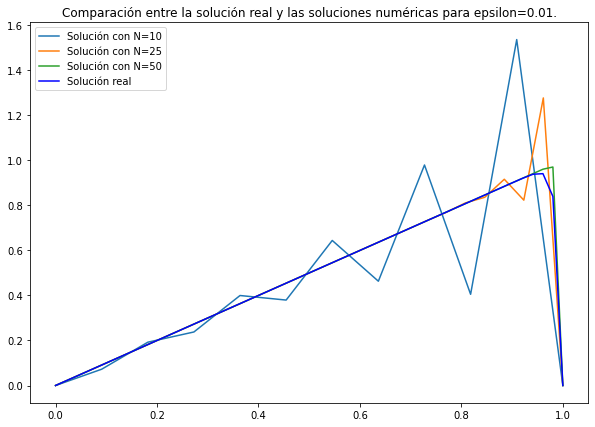

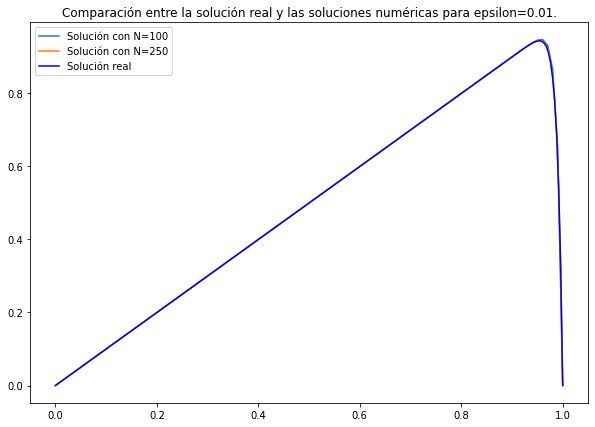

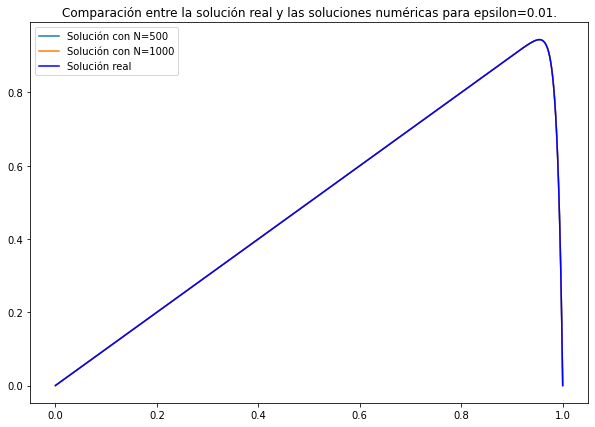

In [7]:
fig=plt.figure(figsize=(10,7))
for i in range(0,3):
    eps_=eps2[1]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.01.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(3,5):
    eps_=eps2[1]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.01.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(5,7):
    eps_=eps2[1]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.01.')
plt.legend()
plt.show()

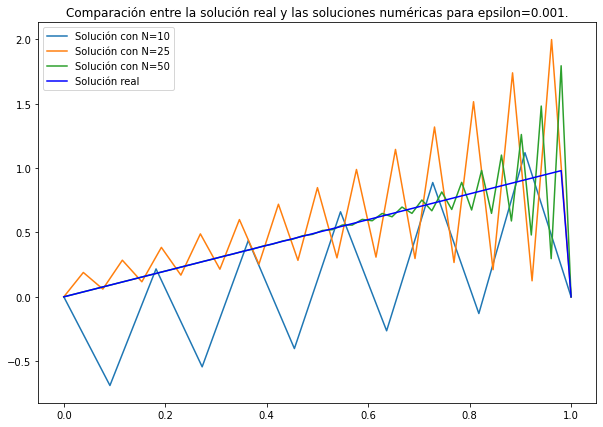

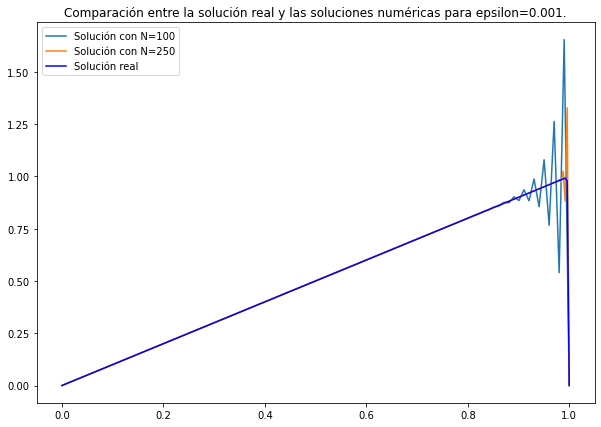

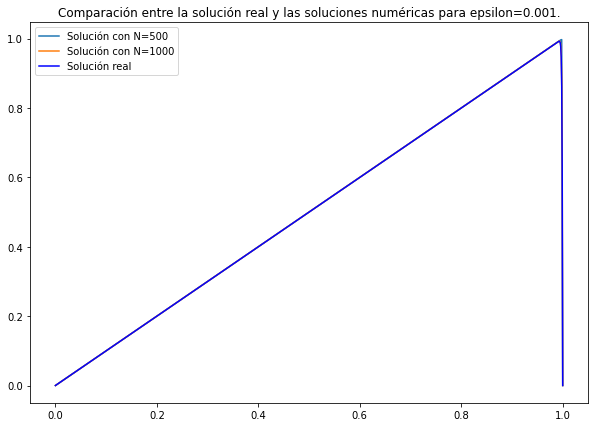

In [8]:
fig=plt.figure(figsize=(10,7))
for i in range(0,3):
    eps_=eps2[2]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.001.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(3,5):
    eps_=eps2[2]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.001.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(5,7):
    eps_=eps2[2]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.001.')
plt.legend()
plt.show()

Al igual que en la parte anterior, se puede apreciar que a medida que aumenta el valor de N, la función aproximada se va suavizando y aproximándose más a la solución real.

Luego, al disminuir el valor de $\epsilon$ se observa que la aproximación entrega valores erráticos para $N$ pequeños, por lo que se necesita aumentar el valor de $N$ para lograr una mejor solución aproximada. En particular, para el valor de $\epsilon=0.1,$ basta considerar un $N$ mayor a $25$ para obtener una aproximación aceptable, mientras que para un $\epsilon=0.001$ se necesita que $N$ sea mayor a $500$ para obtener resultados correctos.

##### Estimación del error


**Teorema:** Sean $\alpha,\beta,u_{\alpha},u_{\beta}\in\mathbb{R}$, $\varepsilon>0$,
$\Omega=\left(  \alpha,\beta\right)  $, $a\in W^{1,\infty}\left(
\Omega\right)  $, $b\in L^{\infty}\left(  \Omega\right)  $ y $f\in
L^{2}\left(  \Omega\right)  $. 
Considere $u$ y $u_{h}$ soluciones únicas de (FV) y (FVD), respectivamente. Entonces, existen constantes $C_{0}>0$ y $C_{1}>0$, independientes de $h$, tales que:
$$
\left\Vert u-u_{h}\right\Vert _{0,\Omega}\leq C_{0}h^{2}\hspace{1cm
}\left\vert u-u_{h}\right\vert _{1,\Omega}\leq C_{1}h
$$


Para hacer este cálculo de forma eficiente, se elegirá una regla de cuadratura conveniente. En primer lugar,
$$\left\Vert u-u_{h}\right\Vert _{0,\Omega}^{2}=\sum_{j=1}^{N}\int_{T_{j}%
}\left(  u\left(  x\right)  -u_{h}\right)  ^{2}\text{ }dx
$$
donde $u_{h}$ es de grado a lo más $1$. Aplicando la regla de Simpson, se
tiene que:
$$
\left\Vert u-u_{h}\right\Vert _{0,\Omega}^{2}=\sum_{j=1}^{N}\dfrac{h_{j}}{6}\left[  \left(  u\left(  x_{j}\right)  -u_{j}^{h}\right)  ^{2}+4\left(
u\left(  \bar{x}_{j}\right)  -\dfrac{u_{j}^{h}+u_{j+1}^{h}}{2}\right)
^{2}+\left(  u\left(  x_{j+1}\right)  -u_{j+1}^{h}\right)  ^{2}\right]
+\mathcal{O}\left(  h_{j}^{5}\right)
$$
Luego, repitiendo el mismo análisis, se tiene que:
$$
\left\vert u-u_{h}\right\vert _{1,\Omega}^{2}=\sum_{j=1}^{N}\int_{T_{j}%
}\left(  u^{\prime}\left(  x\right)  -u_{h}^{\prime}\right)  ^{2}\text{ }dx
$$
donde $u_{h}^{\prime}$ es una función constante a trozos. Entonces, aplicando
la regla del punto medio, se cumple que:
$$
\left\vert u-u_{h}\right\vert _{1,\Omega}^{2}=\sum_{j=1}^{N}h_{j}\left(
u^{\prime}\left(  \bar{x}_{j}\right)  -\dfrac{u_{j+1}-u_{j}}{h_{j}}\right)
^{2}+\mathcal{O}\left(  h_{j}^{3}\right)
$$




c. Considere ahora $\varepsilon = 0.01$ y una discretización uniforme con $N \in \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}$ elementos (es decir, $h_j = h = \frac{1}{N}$). Estime el error en las normas $L^2(\Omega)$, $H^1(\Omega)$ y en la seminorma de $H^1(\Omega)$, grafíquelos y tabúlelos en función de $h$. Para ello, cree una función que permita obtener esos errores. Dicha función debe tener como entradas la discretización del dominio, el vector solución del primer ejercicio, la solución real y su derivada. Las salidas deben ser las normas del error en los espacios $L^2(\Omega)$ y $H^1(\Omega)$, y la seminorma del error en el espacio $H^1(\Omega)$. 

Comente sus resultados.
    
**Indicación:** Puede ser útil usar escala logarítmica para la gráfica de errores. Asimismo, puede resultar útil usar curvas de la forma $Ch$ o $Ch^2$ para comparar las curvas de error con sus respectivos ordenes de convergencia.

In [9]:
def du(x,eps):
    return (np.exp(1/eps)-np.exp(x/eps)/eps-1)/(np.exp(1/eps)-1)

In [10]:
def calcular_errores(eps,Ns,u,du,f):
    """Calcula el error de la solucion al problema (1) para una lista de valores de N"""
    #Parametros
    a=1
    b=0
    ualpha=0
    ubeta=0
    hs=[]
    Error_L=[]
    Error_semi_H1=[]
    Error_H1=[]
    for N in Ns:
        x=np.linspace(0,1,N+2)
        u_aprox=Resuelve(x,ualpha,ubeta,eps,a,b,f)

        #h=[x[1]-x[0]]
        h=np.zeros(N+1)
        error_L=0
        error_semi_H1=0
        error_H1=0
        for j in range(1,len(x)-1):
            #h.append(x[j]-x[j-1])
            h[j]=1/(N+1)
            error_L+=(h[j]/6)*((u(x[j],eps)-u_aprox[j])**2+4*(u((x[j]+x[j+1])/2,eps)-(u_aprox[j]+u_aprox[j+1])/2)**2+(u(x[j+1],eps)-u_aprox[j+1])**2)
            error_semi_H1+=h[j]*(du((x[j+1]+x[j])/2,eps)-(u_aprox[j+1]-u_aprox[j])/h[j])**2
        error_H1=error_L+error_semi_H1
        Error_H1.append(error_H1)
        Error_L.append(error_L)
        Error_semi_H1.append(error_semi_H1)
        hs.append(h[1])
    return hs, Error_L, Error_semi_H1, Error_H1

In [11]:
def tabulador(eps, Ns,u,du,f):
    hs,Error_L,Error_semi_H1,Error_H1=calcular_errores(eps,Ns,u,du,f)
    fig = plt.figure(figsize=(8, 8))
    plt.loglog(hs,Error_L,label=r'Error de $||\cdot||_{L^2}$')
    plt.loglog(hs,Error_semi_H1,label=r'Error de $|\cdot|_{H^1}$')
    plt.loglog(hs,Error_H1,label=r'Error de $||\cdot||_{H^1}$')
    plt.plot(hs,np.square(hs),label=r'$h^{2}$')
    plt.xlabel('Valor de h')
    plt.ylabel('Error')
    plt.title('Error de aproximación en funcion de h')
    plt.legend(loc = 'upper left') #Para que se impriman las leyendas y elegir su ubicación
    plt.show()
    df=pd.DataFrame()
    df['Valor de h']=hs
    df['Error Norma L2']=Error_L
    df['Error Semi-Norma H1']=Error_semi_H1
    df['Error Norma H1']=Error_H1
    return df

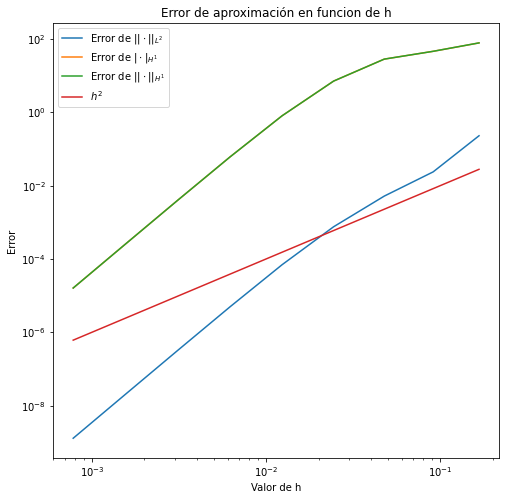

,Valor de h,Error Norma L2,Error Semi-Norma H1,Error Norma H1
0,0.166667,2.286126e-01,77.721202,77.949815
1,0.090909,2.367081e-02,45.919352,45.943023
2,0.047619,5.164431e-03,28.116264,28.121428
3,0.024390,7.538174e-04,7.080665,7.081419
4,0.012346,6.956429e-05,0.801508,0.801578
5,0.006211,4.967891e-06,0.060790,0.060795
6,0.003115,3.237559e-07,0.004025,0.004025
7,0.001560,2.051520e-08,0.000256,0.000256
8,0.000781,1.288651e-09,0.000016,0.000016


In [12]:
Ns=[5,10,20,40,80,160,320,640,1280]
tabulador(0.01, Ns,u,du,f)

La escala logaritmica del error de aproximación en función de $h$ tiene un comportamiento lineal. Se puede observar que a medida que disminuye el valor de $h$, el error también lo hace. Esto se debe a que para valores de h pequeños, el tamaño de $N$ aumenta, por lo que se utilizan más elementos finitos para realizar la aproximación, dando como resultado una función aproximada que se asemeja mucho a la real. 
También podemos notar del gráfico, que los errores obtenidos por las dos normas y la semi-norma convergen más rápido que $Ch^2$ a medida que $N$ aumenta. 


### **Ejercicio 3:** 
Considere $f\equiv1$, $a=0$, $b=1$ y $\Omega=\left(  0,1\right)  $.

Para $u_{\alpha}=1, u_{\beta}=0$, la solución analítica de $\textbf{(P)}$ es única e igual a la
función
$$
u(x)=1-\dfrac
{\sinh\left(\varepsilon^{\frac{-1}{2}}x\right)  }{\sinh\left(\varepsilon^{\frac{-1}{2}}\right)}\hspace{1cm} \forall x\in\left[  0,1\right] 
$$

a. Para una discretización uniforme con $N \in \{5, 10, 20, 40, 80\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$), calcule la solución numérica cuando $\varepsilon = 1$. Grafique todas las soluciones numéricas y la solución analítica (esta última discretizada en una gran cantidad de puntos equiespaciados) en una misma gráfica. Comente sus observaciones.

In [13]:
#Parametros
f= lambda x: x-x+1
a=0
b=1
ualpha=1
ubeta=0
eps=1
N_=[5,10,20,40,80]

In [14]:
def u2(x,eps):
    return 1-(np.sinh(eps**(-0.5)*x))/(np.sinh(eps**(-0.5)))

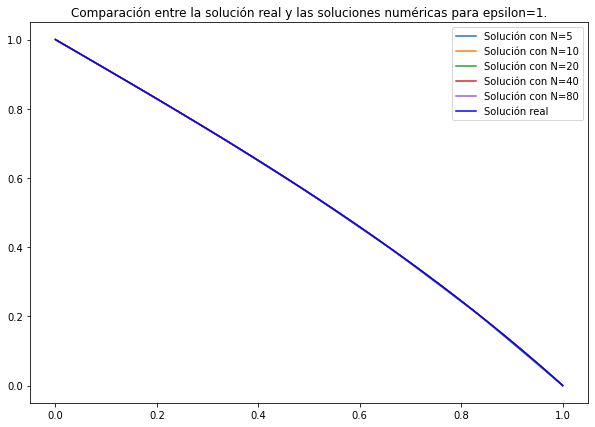

In [15]:
fig=plt.figure(figsize=(10,7))
for i in range(len(N_)):
    x=np.linspace(0,1,N_[i]+2)
    u_aprox2=Resuelve(x,ualpha,ubeta,eps,a,b,f)
    plt.plot(x,u_aprox2,label='Solución con N='+str(N_[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=1.')
plt.legend()

b. Repita lo anterior para $\varepsilon = 10^{−j}$ , con $j \in \{1, 2, 3\}$ y $N \in \{10, 25, 50, 100, 250, 500, 1000\}$. Gráfique los tres primeros valores de $N$ en una figura, los dos siguientes en una distinta y los últimos dos en otra. 
    
    Comente sus observaciones.

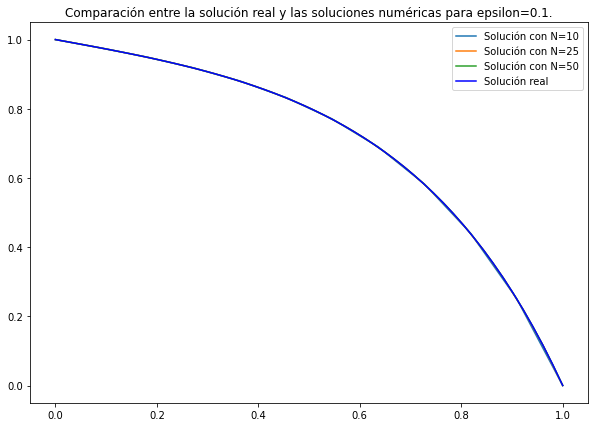

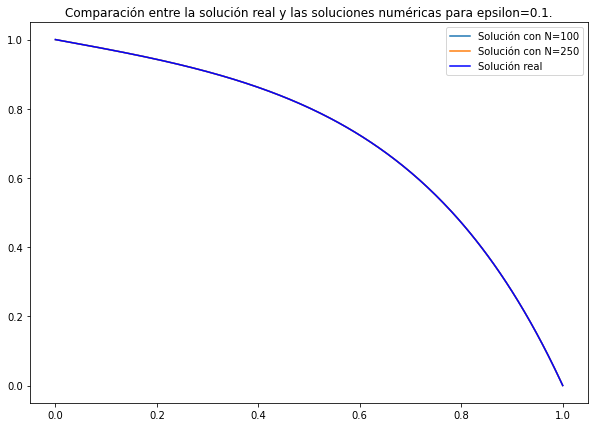

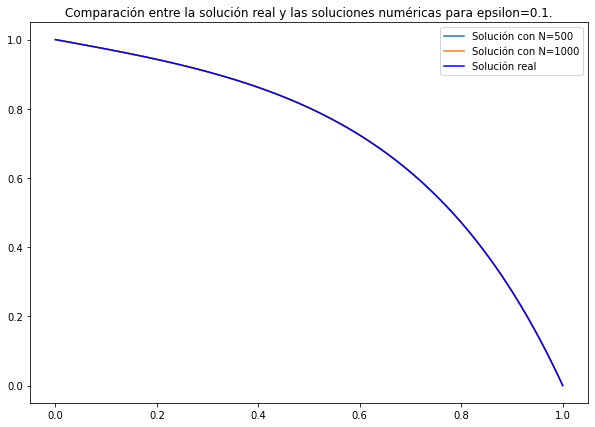

In [16]:
eps2=[10**(-1),10**(-2),10**(-3)]
N_2=[10,25,50,100,250,500,1000]

fig=plt.figure(figsize=(10,7))
for i in range(0,3):
    eps_=eps2[0]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.1.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(3,5):
    eps_=eps2[0]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.1.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(5,7):
    eps_=eps2[0]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.1.')
plt.legend()
plt.show()

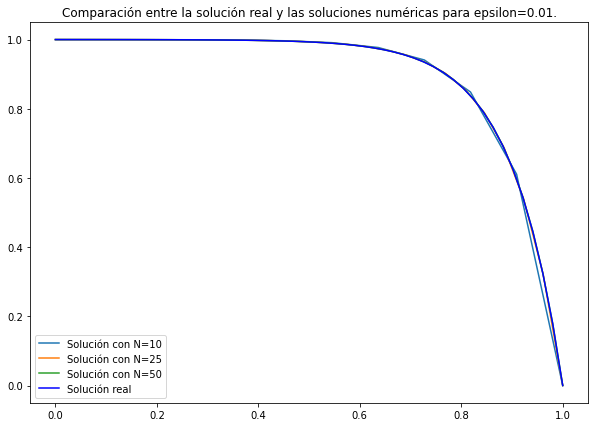

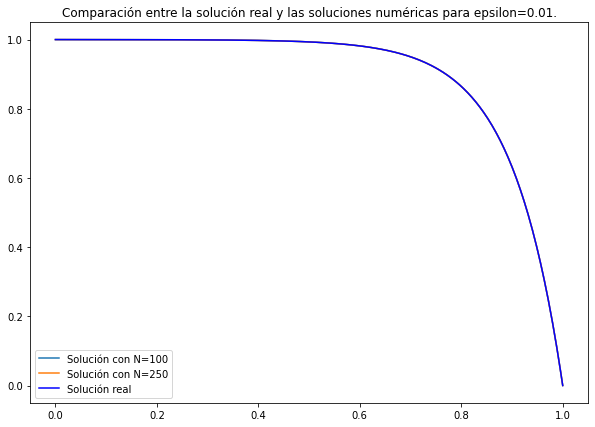

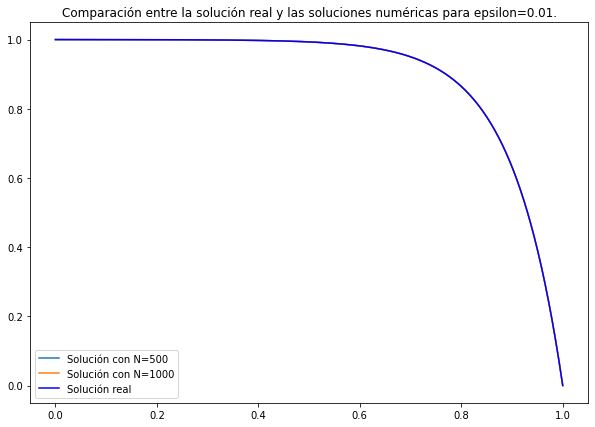

In [17]:
fig=plt.figure(figsize=(10,7))
for i in range(0,3):
    eps_=eps2[1]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.01.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(3,5):
    eps_=eps2[1]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.01.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(5,7):
    eps_=eps2[1]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.01.')
plt.legend()
plt.show()

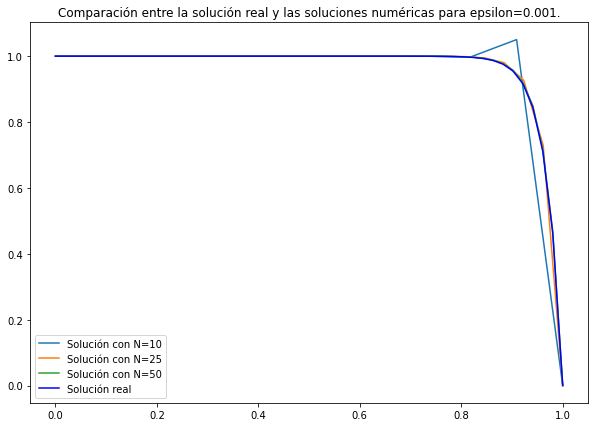

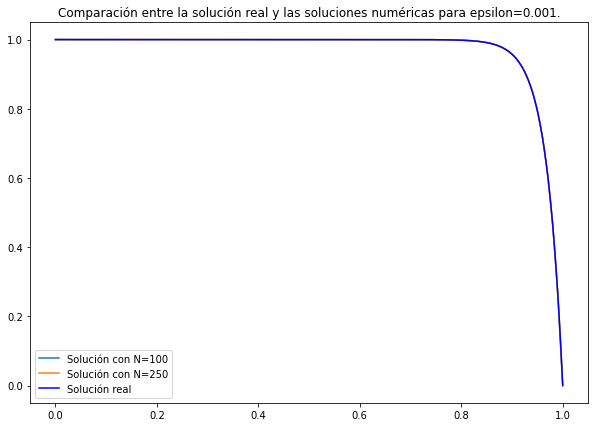

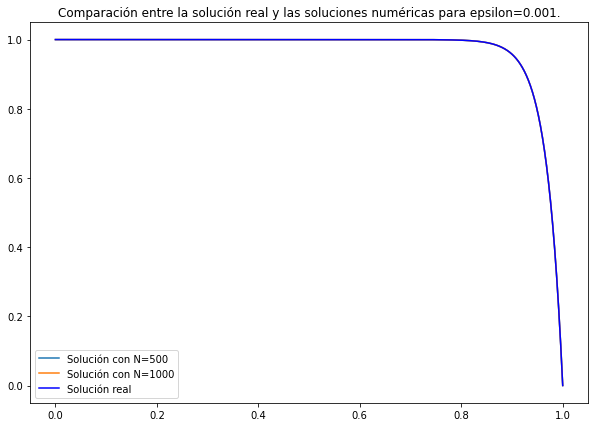

In [18]:
fig=plt.figure(figsize=(10,7))
for i in range(0,3):
    eps_=eps2[2]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.001.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(3,5):
    eps_=eps2[2]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.001.')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,7))
for i in range(5,7):
    eps_=eps2[2]
    x=np.linspace(0,1,N_2[i]+2)
    u_=Resuelve(x,ualpha,ubeta,eps_,a,b,f)
    plt.plot(x,u_,label='Solución con N='+str(N_2[i]))

x2=np.linspace(0,1,10000)
plt.plot(x,u2(x,eps_),label='Solución real',color='b')
plt.title('Comparación entre la solución real y las soluciones numéricas para epsilon=0.001.')
plt.legend()
plt.show()

c. Considere ahora $\varepsilon = 10^{-4}$ y una discretización uniforme con $N \in \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$). Estime el error en las normas $L^2(\Omega)$, $H^1(\Omega)$ y en la seminorma de $H^1(\Omega)$, grafíquelos y tabúlelos en función de $h$. Para ello, cree una función que permita obtener esos errores. Dicha función debe tener como entradas la discretización del dominio, el vector solución del primer ejercicio, la solución real y su derivada. Las salidas deben ser las normas del error en los espacios $L^2(\Omega)$ y $H^1(\Omega)$, y la seminorma del error en el espacio $H^1(\Omega)$. 

Comente sus resultados.
    
**Indicación:** Puede ser útil usar escala logarítmica para la gráfica de errores. Asimismo, puede resultar útil usar curvas de la forma $Ch$ o $Ch^2$ para comparar las curvas de error con sus respectivos ordenes de convergencia.

In [19]:
def du2(x,eps):
    return -(np.cosh(x*eps**(-0.5)))/(eps**(0.5)*np.sinh(eps**(-0.5)))

In [20]:
def calcular_errores2(eps,Ns,u,du,f):
    """Calcula el error de la solucion al problema (1) para una lista de valores de N"""
    #Parametros
    a=0
    b=1
    ualpha=1
    ubeta=0
    hs=[]
    Error_L=[]
    Error_semi_H1=[]
    Error_H1=[]
    for N in Ns:
        x=np.linspace(0,1,N+2)
        u_aprox=Resuelve(x,ualpha,ubeta,eps,a,b,f)

        h=np.zeros(N+1)
        error_L=0
        error_semi_H1=0
        for j in range(1,len(x)-1):
            h[j]=1/(N+1)
            error_L+=(h[j]/6)*((u(x[j],eps)-u_aprox[j])**2+4*(u((x[j]+x[j+1])/2,eps)-(u_aprox[j]+u_aprox[j+1])/2)**2+(u(x[j+1],eps)-u_aprox[j+1])**2)
            error_semi_H1+=h[j]*(du((x[j+1]+x[j])/2,eps)-(u_aprox[j+1]-u_aprox[j])/h[j])**2
        error_H1=error_L+error_semi_H1
        Error_H1.append(error_H1)
        Error_L.append(error_L)
        Error_semi_H1.append(error_semi_H1)
        hs.append(h[1])
    return hs, Error_L, Error_semi_H1, Error_H1

In [21]:
def tabulador2(eps, Ns,u,du,f):
    hs,Error_L,Error_semi_H1,Error_H1=calcular_errores2(eps,Ns,u,du,f)
    fig = plt.figure(figsize=(8, 8))
    plt.loglog(hs,Error_L,label=r'Error de $||\cdot||_{L^2}$')
    plt.loglog(hs,Error_semi_H1,label=r'Error de $|\cdot|_{H^1}$')
    plt.loglog(hs,Error_H1,label=r'Error de $||\cdot||_{H^1}$')
    plt.plot(hs,np.square(hs),label=r'$h^{2}$')
    plt.xlabel('Valor de h')
    plt.ylabel('Error')
    plt.title('Error de aproximación en funcion de h')
    plt.legend(loc = 'upper left') #Para que se impriman las leyendas y elegir su ubicación
    plt.show()
    df=pd.DataFrame()
    df['h']=hs
    df['Error Norma L2']=Error_L
    df['Error Norma H1']=Error_H1
    df['Error Semi-Norma H1']=Error_semi_H1
    return df

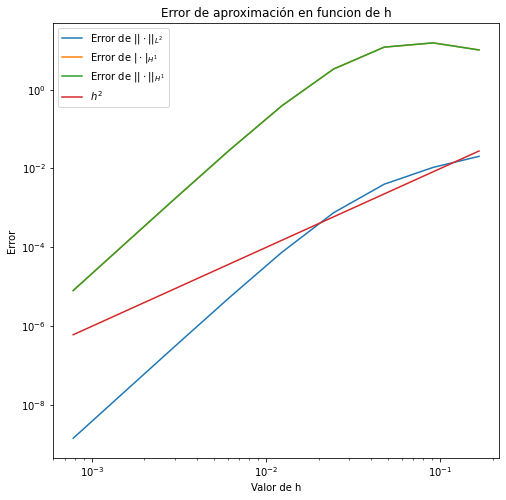

,h,Error Norma L2,Error Norma H1,Error Semi-Norma H1
0,0.166667,2.032564e-02,10.134748,10.114422
1,0.090909,1.066907e-02,15.292414,15.281745
2,0.047619,3.996953e-03,11.940985,11.936988
3,0.024390,7.562428e-04,3.328671,3.327915
4,0.012346,7.589741e-05,0.393060,0.392984
5,0.006211,5.545260e-06,0.030239,0.030234
6,0.003115,3.635066e-07,0.002010,0.002010
7,0.001560,2.306816e-08,0.000128,0.000128
8,0.000781,1.449553e-09,0.000008,0.000008


In [22]:
Ns=[5,10,20,40,80,160,320,640,1280]
tabulador2(0.0001, Ns,u2,du2,f)

Por definición, el valor de $h=\frac{1}{N+1}$ disminuye a medida que el valor de N crece. En el gráfico se observa que además, la escala logaritmica de los errores de aproximación adquieren un comportamiento lineal a medida que el valor de h disminuye. De este comportamiento lineal, se puede inferir que las dos normas y la semi-norma convergen más rapido que $Ch^2$ y por ende, más rapido que $Ch$ también. 

Se puede concluir a partir de los dos casos evaluados, que la error obtenido con la norma $||\cdot ||_{L^2}^2$ es muchisimo menor para cualquier valor de N en comparacion la otra norma y seminorma.  